<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# Procesamiento de lenguaje natural - CEIA
## Alumno: Gonzalo Gontad
## Cohorte: 8va

## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

2023-06-21 08:00:05.570853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 08:00:05.743980: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 08:00:05.746100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 08:00:06.760069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


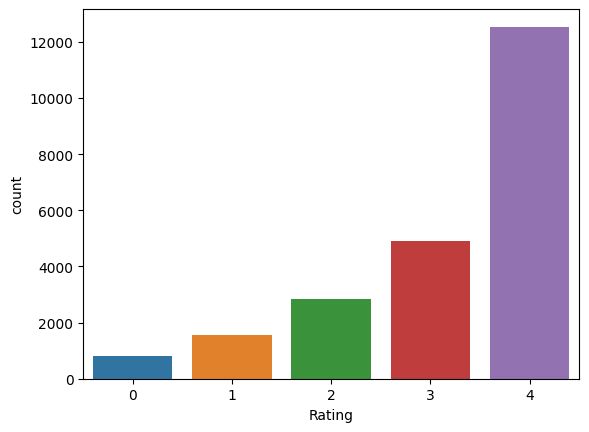

In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
sns.countplot(x='Rating', data=df_reviews)
plt.show()

El dataset esta fuertemente desbalanceado.

In [7]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews_txt = df_reviews['Review Text'].values
for review_txt in reviews_txt[:5]:
    print(review_txt)
    print('**************************************')

Absolutely wonderful - silky and sexy and comfortable
**************************************
Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.
**************************************
I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c
**************************************
I love, love, love this 

In [8]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
print('Cantidad de reviews: ', len(reviews_txt))

Cantidad de reviews:  22641


In [9]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ''
for review_txt in reviews_txt:
    corpus += review_txt + ' '
corpus[:300] #Veo los primeros 300 caracteres

'Absolutely wonderful - silky and sexy and comfortable Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would '

In [10]:
# Alumno: ¿Cuál es la longitud de ese corpus?
print(f'El corpus tiene {len(corpus)} caracteres')

El corpus tiene 7011644 caracteres


In [11]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [12]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[0:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [13]:
# Alumno: ¿Cuántos tokens/palabras hay?
print(f'Hay {len(tokens)} tokens')

Hay 1372203 tokens


In [14]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(tokens)


In [15]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tokenizer.word_index
print(f'Cantidad de palabras en el diccionario: {len(word_index)}')

Cantidad de palabras en el diccionario: 14847


In [16]:
# Alumno: Convertir las palabras/tokens a números
sequences = tokenizer.texts_to_sequences(reviews_txt)


In [17]:
sequences[0]

[253, 532, 917, 3, 662, 3, 68]

In [18]:
#secuencia mas larga
seq_len = [len(s) for s in sequences]
max_seq_len = max(seq_len)

print(f'La secuencia mas larga tiene {max_seq_len} tokens')

La secuencia mas larga tiene 115 tokens


(array([ 827., 2194., 2766., 3168., 2665., 2436., 2300., 3043., 2999.,
         243.]),
 array([  2. ,  13.3,  24.6,  35.9,  47.2,  58.5,  69.8,  81.1,  92.4,
        103.7, 115. ]),
 <BarContainer object of 10 artists>)

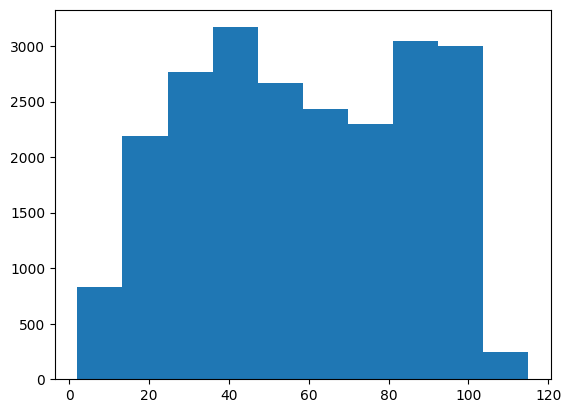

In [19]:
# y también explorar cómo es la distribución de tamaños de secuencias
plt.figure()
plt.hist(seq_len,bins=10)

In [20]:
# Alumno: Determinar cual es la oración más larga
max_sentence_len = max(len(sentence.split()) for sentence in review_txt.split('.') for review_txt in reviews_txt)
max_sentence_len

19

In [21]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences

X = pad_sequences(sequences, maxlen=max_seq_len, padding='pre')

In [22]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [23]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = to_categorical(df_reviews['Rating'].values, num_classes=5)

In [24]:
#Balanceo de clases


In [25]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Balanceo de clases:

In [26]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy="all")

X_train, y_train = oversampler.fit_resample(X_train, y_train )

In [27]:
# Alumno: determinar la dimensiones de entrada y salida
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
print (f'Input dim: {input_dim} Output dim: {output_dim}')

Input dim: 115 Output dim: 5


### 2 - Entrenar el modelo con Embeddings + LSTM

### Modelo con embedding entrenados con el dataset

In [28]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
embedded_dim = 50 # Es la dimensión del vector de embeddings
model.add(Embedding(input_dim=vocab_size+1, output_dim=embedded_dim, input_length=input_dim))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=output_dim, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


2023-06-21 08:00:16.738757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 08:00:16.741113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 08:00:16.742045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 embedding (Embedding)       (None, 115, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 115, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 171,479
Trainable params: 171,479
Non-trainable params: 0
____

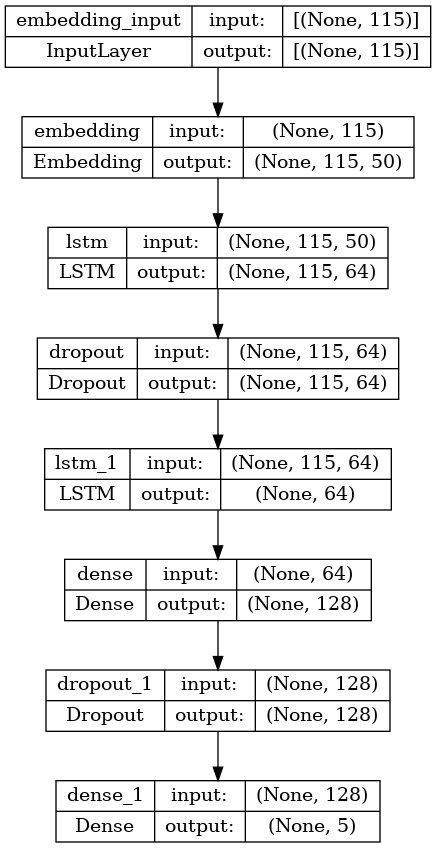

In [29]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
hist = model.fit(X_train, y_train, epochs=20, validation_split=0.2, workers=3)

Epoch 1/20


2023-06-20 17:40:40.097213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-20 17:40:40.099234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-20 17:40:40.100776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1254/1254 [==============================] - ETA: 0s - loss: 0.3540 - accuracy: 0.5631

2023-06-20 17:42:17.365213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-20 17:42:17.366667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-20 17:42:17.367892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1254/1254 [==============================] - 107s 83ms/step - loss: 0.3540 - accuracy: 0.5631 - val_loss: 0.5151 - val_accuracy: 0.1484
Epoch 2/20
1254/1254 [==============================] - 102s 82ms/step - loss: 0.2435 - accuracy: 0.7445 - val_loss: 0.5371 - val_accuracy: 0.2177
Epoch 3/20
1254/1254 [==============================] - 102s 81ms/step - loss: 0.1923 - accuracy: 0.8045 - val_loss: 0.4929 - val_accuracy: 0.3062
Epoch 4/20
1254/1254 [==============================] - 102s 81ms/step - loss: 0.1607 - accuracy: 0.8368 - val_loss: 0.4059 - val_accuracy: 0.3708
Epoch 5/20
1254/1254 [==============================] - 103s 82ms/step - loss: 0.1410 - accuracy: 0.8564 - val_loss: 0.3899 - val_accuracy: 0.4676
Epoch 6/20
1254/1254 [==============================] - 96s 76ms/step - loss: 0.1281 - accuracy: 0.8670 - val_loss: 0.3876 - val_accuracy: 0.4881
Epoch 7/20
1254/1254 [==============================] - 95s 76ms/step - loss: 0.1199 - accuracy: 0.8756 - val_loss: 0.3662 - val_a

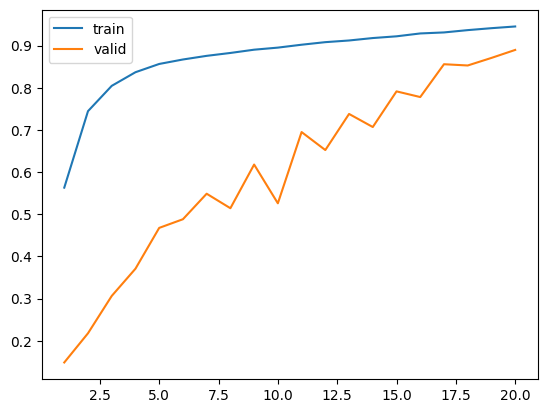

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [32]:
model.evaluate(X_test, y_test)

2023-06-20 18:13:00.662620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-20 18:13:00.663982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-20 18:13:00.664963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

142/142 [==============================] - 5s 30ms/step - loss: 0.6519 - accuracy: 0.5827


[0.6519104242324829, 0.5826893448829651]

### Modelo con embedding Fastext

In [33]:
#!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

In [37]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

#Defino la llase para cargar el embedding pre-entrenado (tomado de la clase 5 de NLP-CEIA)
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


""" class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60 """


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [31]:
model_fasttext = FasttextEmbeddings()

In [32]:
fasttext_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, fasttext_dim))


for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

number of null word embeddings: 2


In [33]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=fasttext_dim, # dimensión de los embeddings utilizados
                     input_length=input_dim, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable
model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=output_dim, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_2 (LSTM)               (None, 115, 64)           93440     
                                                                 
 dropout_2 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         


2023-06-21 08:00:29.831759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 08:00:29.834382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 08:00:29.835808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 735,429
Trainable params: 135,429
Non-trainable params: 600,000
_________________________________________________________________


In [34]:
hist2 = model2.fit(X_train, y_train, epochs=50, validation_split=0.2, workers=3)

Epoch 1/50


2023-06-21 08:00:30.356566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 08:00:30.357780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 08:00:30.358985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1254/1254 [==============================] - ETA: 0s - loss: 1.4747 - accuracy: 0.3533

2023-06-21 08:02:15.253980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 08:02:15.255556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 08:02:15.257290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1254/1254 [==============================] - 115s 90ms/step - loss: 1.4747 - accuracy: 0.3533 - val_loss: 1.9239 - val_accuracy: 0.0040
Epoch 2/50
1254/1254 [==============================] - 109s 87ms/step - loss: 1.2603 - accuracy: 0.4923 - val_loss: 2.0094 - val_accuracy: 0.0210
Epoch 3/50
1254/1254 [==============================] - 108s 86ms/step - loss: 0.9408 - accuracy: 0.6432 - val_loss: 1.6943 - val_accuracy: 0.1122
Epoch 4/50
1254/1254 [==============================] - 108s 86ms/step - loss: 0.7375 - accuracy: 0.7229 - val_loss: 1.7048 - val_accuracy: 0.1732
Epoch 5/50
1254/1254 [==============================] - 109s 87ms/step - loss: 0.6295 - accuracy: 0.7599 - val_loss: 1.5001 - val_accuracy: 0.2376
Epoch 6/50
1254/1254 [==============================] - 109s 87ms/step - loss: 0.5685 - accuracy: 0.7819 - val_loss: 1.4758 - val_accuracy: 0.2210
Epoch 7/50
1254/1254 [==============================] - 108s 86ms/step - loss: 0.5233 - accuracy: 0.7966 - val_loss: 1.3200 - val

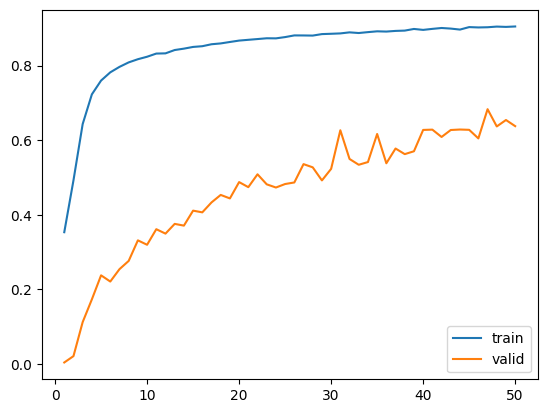

In [35]:
epoch_count2 = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count2,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count2,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [36]:
model2.evaluate(X_test, y_test)

2023-06-21 09:31:55.341103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 09:31:55.342999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 09:31:55.345737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

142/142 [==============================] - 5s 32ms/step - loss: 2.7345 - accuracy: 0.5184


[2.734482526779175, 0.5184367299079895]

## Conclusiones

Se puede observar que el modelo entrenado con fastext requiere mas epocas para llegar a un accuracy similar al modelo con un embedding entrenado con el dataset.

En ninguno de los dos modelos se llego al sobreajuste, por lo que se podria seguir entrenando para mejorar el accuracy.

El uso de fastext no supuso un ahorro de tiempo en el entrenamiento, porque el modelo con fastext requirio mas epocas para llegar a un accuracy similar y el embeddig custom tenia solo 50 dimensiones (6 veces menos que fastext) resultando en 171,479 parametros entrenables contra los 135,429 del modelo con fastext.